In [1]:
#Import Libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping
import os
import shutil
import random

In [2]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Navigate to your folder (replace with your actual folder path)
folder_path = '/content/drive/My Drive/split_dataset'

# List files in the folder
os.listdir(folder_path)

['images', 'split_dataset', 'labels', '__MACOSX']

In [4]:
def load_image_and_label(image_path, label_path, image_size=(224, 224)):
    # Decode image and label paths
    image_path = image_path.numpy().decode('utf-8')
    label_path = label_path.numpy().decode('utf-8')

    # Ensure image_size is a tuple of integers
    # This is crucial as it might be passed as a Tensor from tf.py_function
    image_size_tuple = tuple(int(s) for s in image_size)

    # Read and resize the image
    img = cv2.imread(image_path)
    # Reverse the image_size tuple for cv2.resize to match (width, height)
    # Use the converted tuple
    img = cv2.resize(img, (image_size_tuple[1], image_size_tuple[0]))

    # Apply Median Blur for noise reduction
    img = cv2.medianBlur(img, 5)

    # Normalize image to [0, 1]
    img = img.astype(np.float32) / 255.0

    # Load grayscale and equalize for visualization (optional)
    img_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Reverse the image_size tuple for cv2.resize to match (width, height)
    # Use the converted tuple
    img_gray = cv2.resize(img_gray, (image_size_tuple[1], image_size_tuple[0]))
    equ = cv2.equalizeHist(img_gray)

    # Convert class ID to one-hot/multi-hot label vector
    label_vector = np.zeros(num_classes, dtype=np.float32)
    with open(label_path, 'r') as file:
        for line in file:
            class_id = int(line.strip().split()[0])
            if 0 <= class_id < num_classes:
                label_vector[class_id] = 1.0

    return img, img_gray.astype(np.float32) / 255.0, label_vector

In [10]:
def tf_load_image_and_label(image_path, label_path, image_size=(224, 224)):
    # Convert image_size Tensor to a NumPy array before passing to tf.py_function
    image_size_np = tf.experimental.numpy.asarray(image_size)

    img, img_gray, label_vector = tf.py_function(
        func=load_image_and_label,
        # Pass the numpy array version of image_size
        inp=[image_path, label_path, image_size_np],
        Tout=[tf.float32, tf.float32, tf.float32]
    )

    # Explicitly set shapes after the py_function call
    # Use the original image_size for setting shapes
    img.set_shape((image_size[0], image_size[1], 3))
    img_gray.set_shape((image_size[0], image_size[1]))
    label_vector.set_shape((num_classes,))

    return img, label_vector

In [11]:
def create_dataset(image_dir, label_dir, image_size=(224, 224), batch_size=32, dataset_type='train', show_warnings=True):
    sub_image_dir = os.path.join(image_dir, dataset_type)
    sub_label_dir = os.path.join(label_dir, dataset_type)

    # Get a list of image files
    image_paths = [f for f in os.listdir(sub_image_dir) if f.endswith(('.jpg', '.png'))]

    image_file_paths = []
    label_file_paths = []

    # Check for corresponding label file for each image
    for image_name in image_paths:
        base_name = os.path.splitext(image_name)[0]
        label_name = base_name + '.txt'
        label_path = os.path.join(sub_label_dir, label_name)

        if os.path.exists(label_path):
            image_file_paths.append(os.path.join(sub_image_dir, image_name))
            label_file_paths.append(label_path)
        else:
            if show_warnings:
                print(f"Warning: Missing label file for image: {image_name}")

    if not image_file_paths:
        if show_warnings:
            print(f"Warning: No valid image-label pairs found in {sub_image_dir}")
        return tf.data.Dataset.from_tensor_slices(())

    # Create dataset and map preprocessing
    dataset = tf.data.Dataset.from_tensor_slices((image_file_paths, label_file_paths))
    dataset = dataset.map(
        lambda img_path, lbl_path: tf_load_image_and_label(img_path, lbl_path, image_size),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Shuffle if training
    if dataset_type == 'train':
        dataset = dataset.shuffle(buffer_size=len(image_file_paths))

    # Batch and prefetch
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset

In [12]:
num_classes = 2  # <-- change this if you have a different number of classes

# Define the CNN model
model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

In [13]:
# Define paths to your main image and label directories
image_dir = '/content/drive/My Drive/split_dataset/images'
label_dir = '/content/drive/My Drive/split_dataset/labels'

# Create the training, validation, and test datasets
train_dataset = create_dataset(image_dir, label_dir, image_size=(224, 224), batch_size=32, dataset_type='train')
val_dataset = create_dataset(image_dir, label_dir, image_size=(224, 224), batch_size=32, dataset_type='val')
test_dataset = create_dataset(image_dir, label_dir, image_size=(224, 224), batch_size=32, dataset_type='test')

In [14]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(train_dataset, epochs=30, validation_data=val_dataset, callbacks=[early_stop])
model.evaluate(test_dataset)

Epoch 1/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 333s 7s/step - accuracy: 0.6350 - loss: 0.9865 - val_accuracy: 0.8932 - val_loss: 0.2340
Epoch 2/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 53s 250ms/step - accuracy: 0.8974 - loss: 0.2611 - val_accuracy: 0.9359 - val_loss: 0.1697
Epoch 3/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 56s 300ms/step - accuracy: 0.9319 - loss: 0.1818 - val_accuracy: 0.9872 - val_loss: 0.0602
Epoch 4/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 54s 299ms/step - accuracy: 0.9574 - loss: 0.1110 - val_accuracy: 0.9786 - val_loss: 0.0761
Epoch 5/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 82s 300ms/step - accuracy: 0.9769 - loss: 0.0937 - val_accuracy: 0.9915 - val_loss: 0.0455
Epoch 6/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 57s 302ms/step - accuracy: 0.9614 - loss: 0.1268 - val_accuracy: 0.9957 - val_loss: 0.0354
Epoch 7/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 55s 299ms/step - accuracy: 0.9795 - loss: 0.0602 - val_accuracy: 1.0000 - val_loss: 0.0255
Epoch 8/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 53s 299ms/step - accuracy: 0.9808 - loss: 0.0598 - val_accura

[0.020954936742782593, 0.9915966391563416]

In [15]:
# Access loss and accuracy history
train_loss = history.history['loss']  # List of training loss values per epoch
train_accuracy = history.history['accuracy']  # List of training accuracy values per epoch
val_loss = history.history['val_loss']  # List of validation loss values per epoch
val_accuracy = history.history['val_accuracy']  # List of validation accuracy values per epoch

# Print the final values of loss and accuracy for the last epoch
print(f"Final Training Loss: {train_loss[-1]}")
print(f"Final Training Accuracy: {train_accuracy[-1]}")
print(f"Final Validation Loss: {val_loss[-1]}")
print(f"Final Validation Accuracy: {val_accuracy[-1]}")

Final Training Loss: 0.0423101931810379
Final Training Accuracy: 0.9894815683364868
Final Validation Loss: 0.03273961693048477
Final Validation Accuracy: 0.9914529919624329


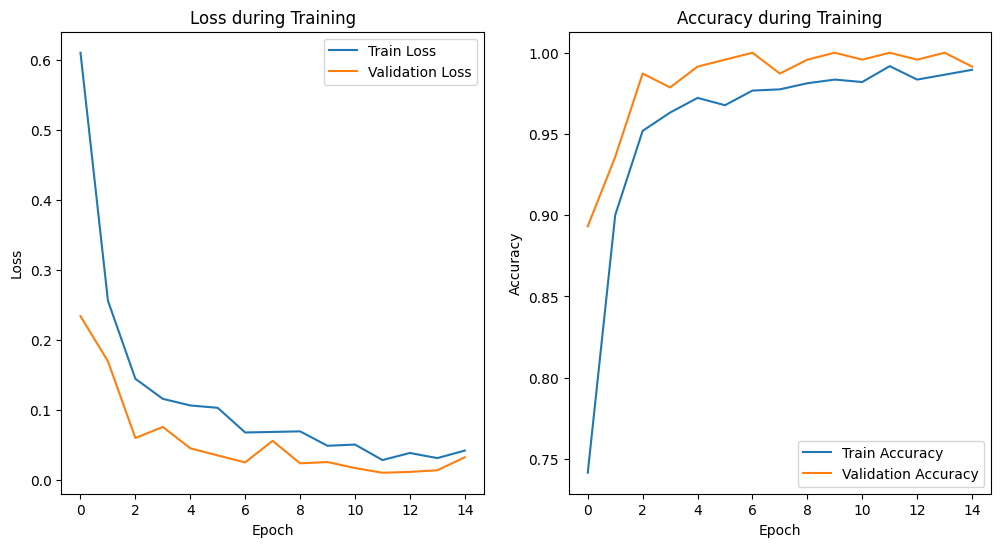

In [16]:
import matplotlib.pyplot as plt

# Plot Training & Validation Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss during Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy during Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [17]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_dataset)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 820ms/step - accuracy: 0.9908 - loss: 0.0281
Test Loss: 0.020954936742782593
Test Accuracy: 0.9915966391563416
